In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [18]:
df_proj_info = pd.read_csv('../data/SBF_project_info_v2.csv')
df_flat_supply_info = pd.read_csv('../data/SBF_flat_supply_info.csv')
df_block_info = pd.read_csv('../data/SBF_block_info.csv')

# Process remaining lease

- Those with a range are applicable to 2-room flexi only (options for lease of 15 - 45 years)
- Since we are interested in 4 rooms and 5 rooms, can just take the upper limit of the lease

In [19]:
df_proj_info['Remaining_Lease_years'] = (
    df_proj_info['Remaining_Lease']
    .str.extract('(\d+) years')
    .astype(int)
    .squeeze()
    .tolist()
)

# Get latest completion date

- When the completion date is given as a range, take the latest date

In [20]:
sel = df_proj_info['Est_Completion'] != 'Keys Available'

df_proj_info.loc[sel, 'Est_Completion'] = (
    df_proj_info.loc[sel, 'Est_Completion']
    .str.extract('(\d{1,2}/\d{4})$')
    .squeeze()
    .tolist()
)

In [21]:
sel = df_proj_info['Est_Completion'] == 'Keys Available'
df_proj_info.loc[sel, 'Est_Completion'] = '6/2021'

In [22]:
df_proj_info['Est_Completion'] = pd.to_datetime(df_proj_info['Est_Completion'])

In [26]:
df_proj_info['flat_type'] = df_proj_info['flat_type'].str.title()

In [47]:
df_proj_info['floor_num'] = (
    df_proj_info['floor_num']
    .str.extract('(\d+)')
    .squeeze()
    .astype(int)
    .tolist()
)

# Combine block_info and flat_supply_info

- Get the number of units available for each race by flat type

In [27]:
# Process flatType in block_info so that it is the same as flat_supply_info

df_block_info['flatType'] = df_block_info['flatType'].str.title()

In [28]:
ethnic_quota = (
    df_block_info
    .groupby(['proj_id','flatType'])
    [['chinese','malay','indian']]
    .sum()
)

In [29]:
df_flat_info = (
    df_flat_supply_info
    .set_index(['proj_id','flatType'])
    .merge(ethnic_quota, left_index=True, right_index=True)
    .reset_index()
)

In [32]:
df_flat_info.rename(columns={'flatType':'flat_type'}, inplace=True)

# Get current application status

1. Application for 5-Room, 3Gen and Executive are grouped together, so using it as the figure for 5-Room is an overestimate
2. Application count derived from the application rates tend to be lower than given application count, thus the figure could be an underestimate

Thus, the estimates for 5-Room in general is not as reliable as 4-Room.

In [70]:
df_app_status = pd.read_csv('../data/SBF_application_status_0528_1255.csv')

In [100]:
sel = df_app_status['flat_type'].str.startswith('5-Room')

df_app_status.loc[sel, 'flat_type'] = '5-Room'

# Selection & Generate data

In [147]:
(
    df_proj_info_selected
    .query('town == "Toa Payoh" and flat_type == "4-Room"')
    [['supply','supply_within_crit','chinese']]
    .sum()
)

supply                132
supply_within_crit    132
chinese                82
dtype: int64

In [151]:
# Select and count number of rooms that meets our criteria
min_floor = 10
min_lease = 90
flat_selection = ['4-Room','5-Room']
latest_comp = datetime(2022,6,1)

# min_floor = 10
# min_lease = 90
# flat_selection = ['4-Room','5-Room']
# latest_comp = datetime(2022,1,1)


sel = (
    (df_proj_info['Remaining_Lease_years'] >= min_lease) &
    (df_proj_info['floor_num'] >= min_floor) &
    (df_proj_info['flat_type'].isin(flat_selection)) &
    (df_proj_info['Est_Completion'] <= latest_comp)
)


# Get project supply info tts within selection criteria
df_proj_info_selected = (
    df_proj_info
    .loc[sel]
    .groupby(['proj_id','flat_type'])
    .agg(
        town=('Town', 'first'),
        supply_within_crit=('Town','count')
    )
    .reset_index()
)

# Merge with flat info
df_proj_info_selected = (
    df_proj_info_selected
    .merge(df_flat_info, on=['proj_id','flat_type'])
)

# Select the upper limit of supply
df_proj_info_selected['supply_within_crit_n_quota'] = (
    df_proj_info_selected[['supply_within_crit','chinese']].min(axis=1)
)

# Merge application status 
df_merged = (
    df_proj_info_selected
    .groupby(['town','flat_type'], as_index=False)
    [['supply_within_crit_n_quota']]
    .sum()
    .merge(
        df_app_status[['town','flat_type','num_first_timers']],
        on=['town','flat_type']
    )
)

# Calculate adjusted chance
df_merged['adjusted_chance_pc'] = (
    (df_merged['supply_within_crit_n_quota'] / df_merged['num_first_timers'] * 100)
    .round(1)
)

# Show results
df_merged.sort_values('adjusted_chance_pc', ascending=False)

,town,flat_type,supply_within_crit_n_quota,num_first_timers,adjusted_chance_pc
28,Yishun,5-Room,5,46,10.9
14,Punggol,4-Room,41,436,9.4
20,Sengkang,4-Room,15,251,6.0
15,Punggol,5-Room,11,219,5.0
9,Clementi,4-Room,10,229,4.4
27,Yishun,4-Room,8,184,4.3
2,Bedok,5-Room,2,48,4.2
3,Bukit Batok,4-Room,10,256,3.9
13,Pasir Ris,4-Room,1,27,3.7
6,Bukit Panjang,5-Room,2,60,3.3


In [183]:
sel = (
    (proj_info['Town'] == 'Punggol') &
    (proj_info['flat_type'] == '4-Room')
)

proj_info.loc[sel,['proj_id','flat_type','floor_num','unit_size','unit_price']].sort_values('unit_price').tail(10)

,proj_id,flat_type,floor_num,unit_size,unit_price
281,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,4-Room,22,93 sqm,"$380,500"
312,2021-05_SBF_UEdfUzRDN18xNjE5NTA5ODQ5NzE2,4-Room,18,94 sqm,"$381,200"
274,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,4-Room,17,93 sqm,"$381,600"
333,2021-05_SBF_UEdfUzRDNl8xNjE5NTA5ODQ5NzEz,4-Room,15,94 sqm,"$382,400"
218,2021-05_SBF_UEdfUzRDMl8xNjE5NTA5ODQ5Njc3,4-Room,19,94 sqm,"$383,500"
273,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,4-Room,20,93 sqm,"$386,100"
318,2021-05_SBF_UEdfUzRDN18xNjE5NTA5ODQ5NzE2,4-Room,18,94 sqm,"$389,300"
272,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,4-Room,23,93 sqm,"$390,600"
320,2021-05_SBF_UEdfUzRDN18xNjE5NTA5ODQ5NzE2,4-Room,23,94 sqm,"$391,800"
317,2021-05_SBF_UEdfUzRDN18xNjE5NTA5ODQ5NzE2,4-Room,22,94 sqm,"$394,900"


In [184]:
sel = (
    (proj_info['Town'] == 'Punggol') &
    (proj_info['flat_type'] == '5-Room')
)

proj_info.loc[sel,['proj_id','flat_type','floor_num','unit_size','unit_price']].sort_values('unit_price').tail(10)

,proj_id,flat_type,floor_num,unit_size,unit_price
331,2021-05_SBF_UEdfUzRDNl8xNjE5NTA5ODQ5NzEz,5-Room,22,112 sqm,"$502,100"
269,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,5-Room,7,113 sqm,"$502,300"
284,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,5-Room,11,113 sqm,"$503,400"
315,2021-05_SBF_UEdfUzRDN18xNjE5NTA5ODQ5NzE2,5-Room,25,112 sqm,"$512,100"
283,2021-05_SBF_UEdfUzRDMTQtQzE1XzE2MTk1MDk4NDk4Njg,5-Room,13,113 sqm,"$513,400"
225,2021-05_SBF_UEdfUzRDMl8xNjE5NTA5ODQ5Njc3,5-Room,7,115 sqm,"$520,500"
325,2021-05_SBF_UEdfUzRDNF8xNjE5NTA5ODQ5NzA5,5-Room,12,116 sqm,"$523,400"
303,2021-05_SBF_UEdfUzRDMV8xNjE5NTA5ODQ5NjYy,5-Room,21,112 sqm,"$528,100"
221,2021-05_SBF_UEdfUzRDMl8xNjE5NTA5ODQ5Njc3,5-Room,19,115 sqm,"$543,200"
220,2021-05_SBF_UEdfUzRDMl8xNjE5NTA5ODQ5Njc3,5-Room,25,115 sqm,"$554,800"


In [185]:
proj_info

,Town,Remaining_Lease,Est_Completion,proj_id,blk_num,flat_type,floor_num,unit_num,unit_size,unit_price,precinct_name,Remaining_Lease_years
0,Bukit Batok,15 - 99 years,2022-01-01,2021-05_SBF_QkJfTjFDMTVfMTYxOTUwOTg0NzQwMg,Blk 114A,2-Room Flexi,12,516,47 sqm,"$179,600",Sky Vista @ Bukit Batok,99
1,Bukit Batok,15 - 99 years,2022-01-01,2021-05_SBF_QkJfTjFDMTVfMTYxOTUwOTg0NzQwMg,Blk 114B,2-Room Flexi,8,508,47 sqm,"$188,100",Sky Vista @ Bukit Batok,99
2,Bukit Batok,63 years,2021-06-01,2021-05_SBF_QkJfTjFDOUFfMTYyMDIxMDYwMDEwNA,Blk 167,4-Room,2,236 *,103 sqm,"$275,000",Bt Batok West Ave 8,63
3,Bukit Batok,15 - 45 years,2021-06-01,2021-05_SBF_QkJfTjJDMjFfMTYyMDQ1MzI0MDE0OA,Blk 230A,2-Room Flexi,10,415 *,47 sqm,"$98,100",Golden Daisy,45
4,Bukit Batok,15 - 45 years,2021-06-01,2021-05_SBF_QkJfTjJDMjFfMTYyMDQ1MzI0MDE0OA,Blk 230A,2-Room Flexi,7,421 *,37 sqm,"$77,100",Golden Daisy,45
...,...,...,...,...,...,...,...,...,...,...,...,...
2489,Jurong West,15 - 99 years,2022-11-01,2021-05_SBF_SldfTjJDMjBfMTYxOTUwOTg0OTMwMA,Blk 238B,2-Room Flexi,9,277,38 sqm,"$139,900",Boon Lay Glade,99
2490,Jurong West,15 - 99 years,2022-11-01,2021-05_SBF_SldfTjJDMjBfMTYxOTUwOTg0OTMwMA,Blk 238B,3-Room,12,267,68 sqm,"$255,000",Boon Lay Glade,99
2491,Jurong West,15 - 99 years,2022-11-01,2021-05_SBF_SldfTjJDMjBfMTYxOTUwOTg0OTMwMA,Blk 238B,3-Room,11,269,68 sqm,"$257,100",Boon Lay Glade,99
2492,Jurong West,15 - 99 years,2022-11-01,2021-05_SBF_SldfTjJDMjBfMTYxOTUwOTg0OTMwMA,Blk 238B,4-Room,10,261,93 sqm,"$387,400",Boon Lay Glade,99


In [14]:
sel = df_flat_info['flat_type'].isin(flat_selection)

df_merged = (
    df_flat_info
    .loc[sel]
    .merge(
        df_proj_info,
        on='proj_id'
    )
)

In [15]:
df_merged

,proj_id,flatType,supply,price_range_upper,price_range_lower,chinese,malay,indian,Town,Remaining_Lease,Est_Completion,blk_num,flat_type,floor_num,unit_num,unit_size,unit_price,precinct_name,Remaining_Lease_years
0,2021-05_SBF_QkJfTjFDOUFfMTYyMDIxMDYwMDEwNA,4-Room,1,275000,275000,1,1,1,Bukit Batok,63 years,2021-06-01,Blk 167,4-room,#02,236 *,103 sqm,"$275,000",Bt Batok West Ave 8,63
1,2021-05_SBF_QkJfTjJDMjNfMTYyMDM2MTMyMDM0Nw,4-Room,1,361500,361500,1,1,1,Bukit Batok,96 years,2021-06-01,Blk 296C,4-room,#07,86 *,92 sqm,"$361,500",Skyline II @ Bukit Batok,96
2,2021-05_SBF_QkJfTjNDM18xNjIwMjEwNjAwMTA2,4-Room,1,265000,265000,1,1,1,Bukit Batok,64 years,2021-06-01,Blk 316,4-room,#06,133 *,93 sqm,"$265,000",Bt Batok St 32,64
3,2021-05_SBF_QkJfTjRDMjJfMTYxOTUwOTg0NzY5Ng,4-Room,9,320500,278500,9,5,9,Bukit Batok,15 - 99 years,2021-11-01,Blk 431A,2-room Flexi,#13,1649,47 sqm,"$136,100",West Scape @ Bukit Batok,99
4,2021-05_SBF_QkJfTjRDMjJfMTYxOTUwOTg0NzY5Ng,4-Room,9,320500,278500,9,5,9,Bukit Batok,15 - 99 years,2021-11-01,Blk 431A,2-room Flexi,#04,1651,47 sqm,"$122,600",West Scape @ Bukit Batok,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3698,2021-05_SBF_VEFQX044QzMxXzE2MTk1MDk4NTA5ODA,5-Room,5,607800,567800,5,5,5,Tampines,15 - 99 years,2023-01-01,Blk 860D,3-room,#13,203,69 sqm,"$321,500",Tampines Greenspring,99
3699,2021-05_SBF_VEFQX044QzMxXzE2MTk1MDk4NTA5ODA,5-Room,5,607800,567800,5,5,5,Tampines,15 - 99 years,2023-01-01,Blk 860D,3-room,#07,205,69 sqm,"$315,700",Tampines Greenspring,99
3700,2021-05_SBF_VEFQX044QzMxXzE2MTk1MDk4NTA5ODA,5-Room,5,607800,567800,5,5,5,Tampines,15 - 99 years,2023-01-01,Blk 860D,3-room,#02,203,69 sqm,"$290,400",Tampines Greenspring,99
3701,2021-05_SBF_VEFQX044QzMxXzE2MTk1MDk4NTA5ODA,5-Room,5,607800,567800,5,5,5,Tampines,15 - 99 years,2023-01-01,Blk 860D,5-room,#13,197,113 sqm,"$597,200",Tampines Greenspring,99


In [15]:
df_merged['Lease'] = (df_merged['Remaining_Lease_years'] >= 95).map({True:'95 years +',False:'< 95 years'})

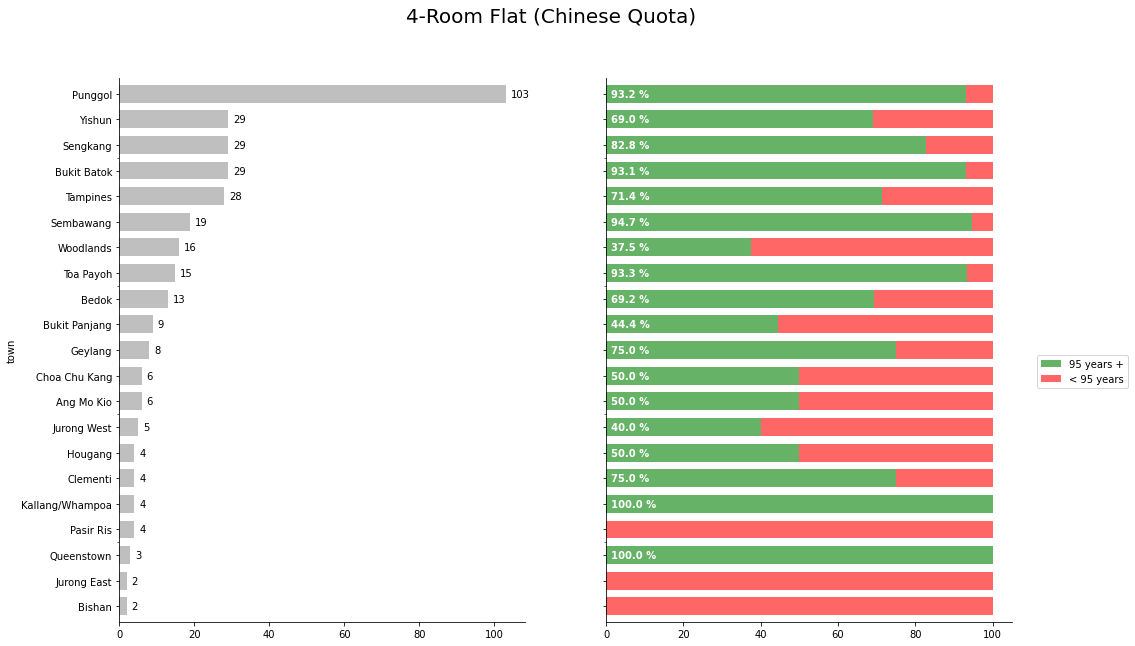

In [22]:
sel = (df_merged['flatType'] == '4-Room') & (df_merged['chinese'] > 0) & (df_merged['Est_Completion'] <= datetime(2021,12,1))

# Get HDB age count
hdb_age = (
    df_merged
    .loc[sel]
    .groupby(['town','Lease'])
    ['chinese']
    .sum()
    .unstack()
    .fillna(0)
    .astype(int)
)

hdb_age['total'] = hdb_age.sum(axis=1)

# Get normalized HDB age count

hdb_age_norm = hdb_age.copy()

hdb_age_norm['95 years +'] = hdb_age_norm['95 years +'] / hdb_age_norm['total'] * 100
hdb_age_norm['< 95 years'] = hdb_age_norm['< 95 years'] / hdb_age_norm['total'] * 100

del hdb_age_norm['total']

# Plot charts

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,10), sharey=True)

hdb_age['total'].sort_values().plot(kind='barh', ax=ax1, width=0.7, color='grey', alpha=0.5)

(
    hdb_age_norm
    .loc[hdb_age['total'].sort_values().index]
    .plot(kind='barh', stacked=True, ax=ax2, width=0.7, color=['green','red'], alpha=0.6)
)

for a in [ax1, ax2]:
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    

for p in ax1.patches:
    ax1.annotate(
        f'{p.get_width()}', 
        (p.get_width(), p.get_height() /2. + p.get_y()),
        textcoords='offset points',
        xytext=(5,0),
        va='center'
                )

for p in ax2.patches[:len(hdb_age_norm)]:
    if p.get_x() == 0 and (p.get_width() > 10):
        ax2.annotate(
            f'{p.get_width():.1f} %', 
            (0, p.get_height() /2. + p.get_y()),
            textcoords='offset points',
            xytext=(5,0),
            va='center',
            color='white',
            weight='heavy'
        )
    
ax2.legend(bbox_to_anchor=(1.05, 0.5))

fig.suptitle('4-Room Flat (Chinese Quota)', fontsize=20)

plt.show()

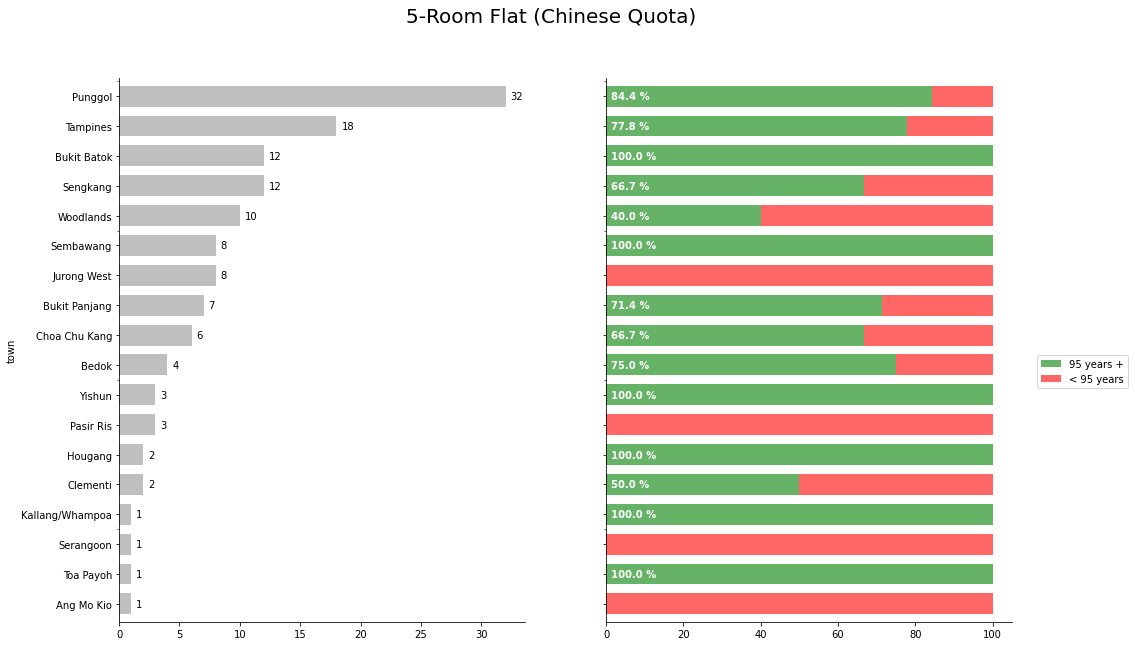

In [23]:
sel = (df_merged['flatType'] == '5-Room') & (df_merged['chinese'] > 0) & (df_merged['Est_Completion'] <= datetime(2021,12,1))

# Get HDB age count
hdb_age = (
    df_merged
    .loc[sel]
    .groupby(['town','Lease'])
    ['chinese']
    .sum()
    .unstack()
    .fillna(0)
    .astype(int)
)

hdb_age['total'] = hdb_age.sum(axis=1)

# Get normalized HDB age count

hdb_age_norm = hdb_age.copy()

hdb_age_norm['95 years +'] = hdb_age_norm['95 years +'] / hdb_age_norm['total'] * 100
hdb_age_norm['< 95 years'] = hdb_age_norm['< 95 years'] / hdb_age_norm['total'] * 100

del hdb_age_norm['total']

# Plot charts

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,10), sharey=True)

hdb_age['total'].sort_values().plot(kind='barh', ax=ax1, width=0.7, color='grey', alpha=0.5)

(
    hdb_age_norm
    .loc[hdb_age['total'].sort_values().index]
    .plot(kind='barh', stacked=True, ax=ax2, width=0.7, color=['green','red'], alpha=0.6)
)

for a in [ax1, ax2]:
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    

for p in ax1.patches:
    ax1.annotate(
        f'{p.get_width()}', 
        (p.get_width(), p.get_height() /2. + p.get_y()),
        textcoords='offset points',
        xytext=(5,0),
        va='center'
                )

for p in ax2.patches[:len(hdb_age_norm)]:
    if p.get_x() == 0 and (p.get_width() > 10):
        ax2.annotate(
            f'{p.get_width():.1f} %', 
            (0, p.get_height() /2. + p.get_y()),
            textcoords='offset points',
            xytext=(5,0),
            va='center',
            color='white',
            weight='heavy'
        )
    
ax2.legend(bbox_to_anchor=(1.05, 0.5))

fig.suptitle('5-Room Flat (Chinese Quota)', fontsize=20)

plt.show()

In [ ]:
sel = (
    (df_merged['flatType'] == '5-Room') &
    (df_merged['chinese'] > 0) &
    (df_merged['Lease'] == '95 years +')
)

df_temp = (
    df_merged
    .loc[sel]
)

df_temp = (
    df_temp
    .loc[
        df_temp.index.repeat(df_temp['supply']),
        ['Est_Completion', 'town']]
)

In [ ]:
df_temp['Est_Completion'].value_counts().sort_index().plot(kind='bar')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,4))

df_temp["Est_Completion"].astype(np.int64).plot.hist(ax=ax)
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(labels)
ax.set_xticklabels(labels, rotation=90)


In [ ]:
labels